In [1]:
from utils_for_supersinglets import *
from qiskit.converters import circuit_to_dag, dag_to_circuit

In [2]:
qcs, results, infos = nontrival_construction_1(6, error_rate=1e-7)

Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instruction.
Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instruction.
Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instruction.
Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instruction.
Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instruction.
Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instruction.
Simulation failed and returned the following error message:
ERROR: Failed to load circuits: Duplicate key "density_matrix" in save instr

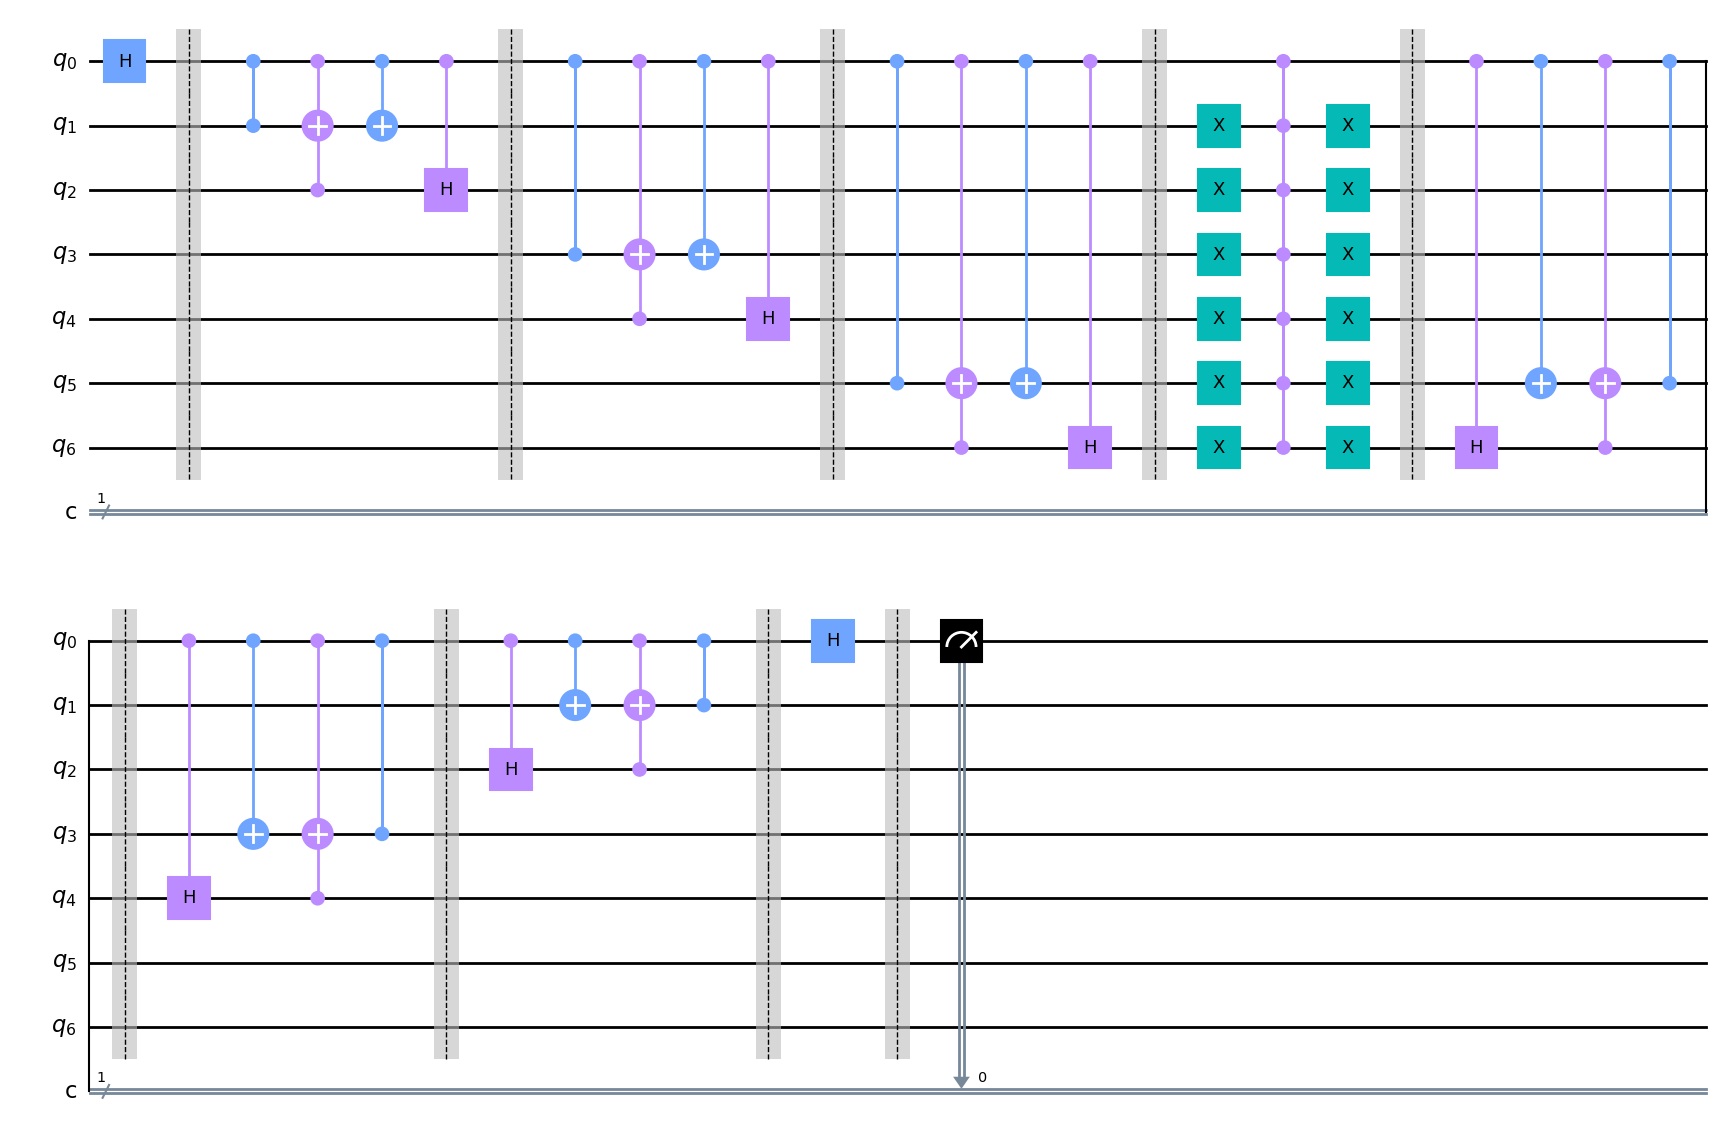

In [3]:
qcs[1].draw('mpl')

In [4]:
def decompose_6_qubit_circuit(qc):
    dag = circuit_to_dag(qc)
    qubit_number = qc.num_qubits
    decomposed_circuit = QuantumCircuit(qubit_number)
    for layer in dag.layers():
        layer_as_circuit = dag_to_circuit(layer['graph'])
        if 'ccx' in layer_as_circuit.count_ops().keys():
            decomposed_circuit = decomposed_circuit.compose(layer_as_circuit, qubits=range(qubit_number))
        elif 'cz' in layer_as_circuit.count_ops().keys():
            gate, qargs, cargs = layer_as_circuit.data[0]
            control_qubit = qargs[0].index
            target_qubit = qargs[1].index
            decomposed_circuit.h(target_qubit)
            decomposed_circuit.cx(control_qubit, target_qubit)
            decomposed_circuit.h(target_qubit)
        elif 'ch' in layer_as_circuit.count_ops().keys():
            tmp_qc = QuantumCircuit(qubit_number)
            gate, qargs, cargs = layer_as_circuit.data[0]
            control_qubit = qargs[0].index
            target_qubit = qargs[1].index
            tmp_qc.ry(-np.pi/4, target_qubit)
            tmp_qc.h(target_qubit)
            tmp_qc.cx(control_qubit, target_qubit)
            tmp_qc.h(target_qubit)
            tmp_qc.ry(np.pi/4, target_qubit)
            decomposed_circuit = decomposed_circuit.compose(tmp_qc, qubits=range(qubit_number))
        elif 'measure' in layer_as_circuit.count_ops().keys():
            continue
        elif 'c6z' in layer_as_circuit.count_ops().keys():
            tmp_qc = QuantumCircuit(qubit_number)
            gate, qargs, cargs = layer_as_circuit.data[0]
            control_qubits = [qarg.index for qarg in qargs[:-1]]
            target_qubit = qargs[-1].index
            mcz = MCMT('cz', len(control_qubits), 1)
            applied_qubits = control_qubits + [target_qubit]
            tmp_qc = tmp_qc.compose(mcz, qubits=applied_qubits)
            tmp_qc_decompose = tmp_qc.decompose(reps=2)
            sub_dag = circuit_to_dag(tmp_qc_decompose)
            for sub_layer in sub_dag.layers():
                sub_layer_as_circuit = dag_to_circuit(sub_layer['graph'])
                if 'cx' in sub_layer_as_circuit.count_ops().keys():
                    _, sub_qargs, _ = sub_layer_as_circuit.data[0]
                    control_qubit = sub_qargs[0].index
                    target_qubit = sub_qargs[1].index
                    decomposed_circuit.h(target_qubit)
                    decomposed_circuit.cz(control_qubit, target_qubit)
                    decomposed_circuit.h(target_qubit)
                else:
                    decomposed_circuit = decomposed_circuit.compose(sub_layer_as_circuit, qubits=range(qubit_number))
        else:
            decomposed_circuit = decomposed_circuit.compose(layer_as_circuit, qubits=range(qubit_number))
    return decomposed_circuit

In [5]:
decomposed_circuits = [-1]

for i in range(1, len(qcs)):
    decomposed_circuits.append(decompose_6_qubit_circuit(qcs[i]))

/var/folders/d5/z46p1gs16y75dvk_xd3lphdh0000gn/T/ipykernel_66597/2527912915.py:11: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  control_qubit = qargs[0].index
/var/folders/d5/z46p1gs16y75dvk_xd3lphdh0000gn/T/ipykernel_66597/2527912915.py:12: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  target_qubit = qargs[1].index
/var/folders/d5/z46p1gs16y75dvk_xd3lphdh0000gn/T/ipykernel_66597/25279129

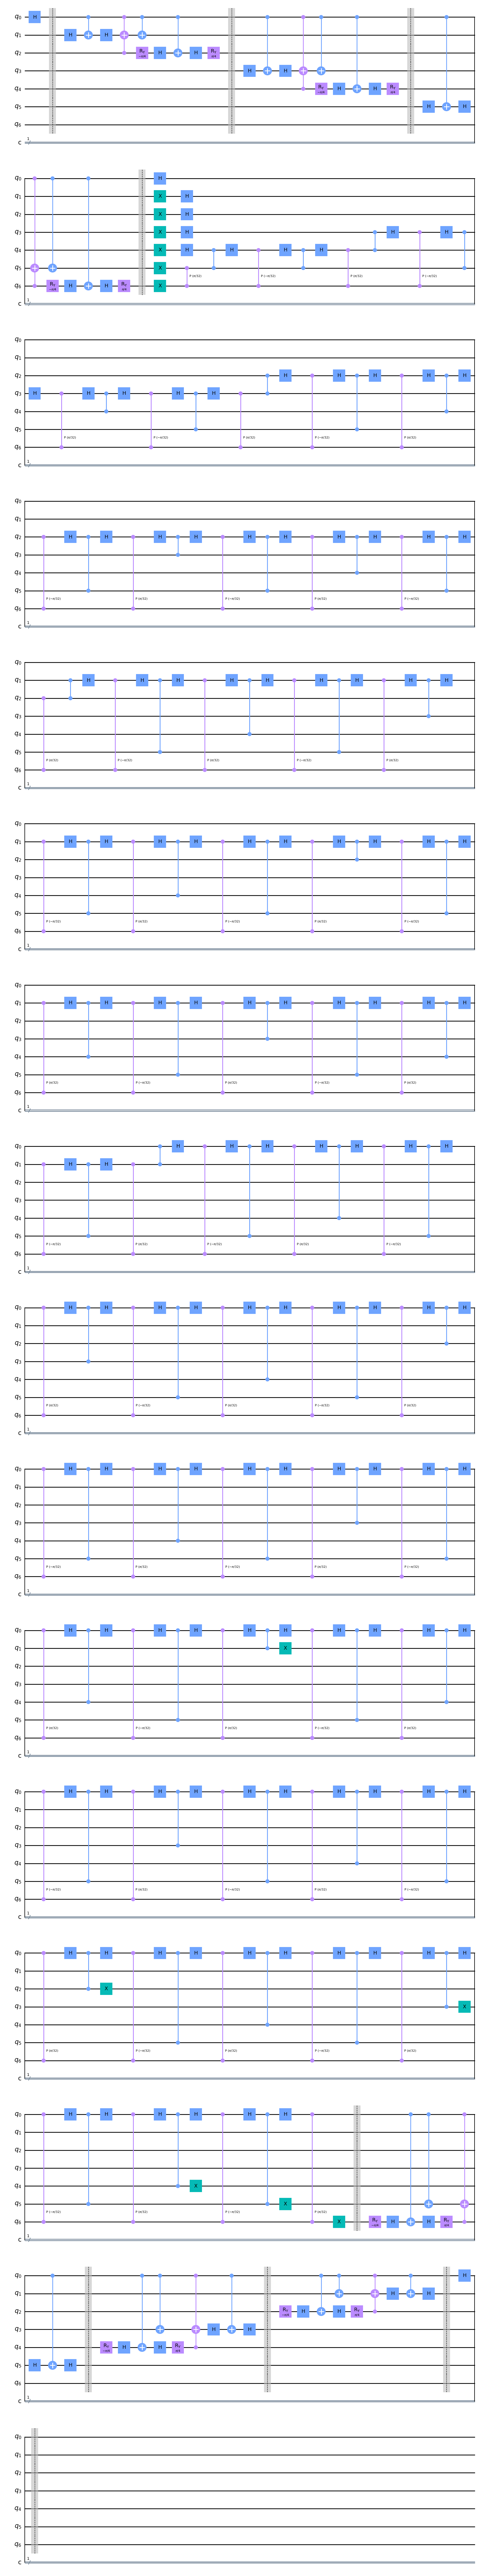

In [6]:
decomposed_circuits[1].draw('mpl')

In [7]:
correct_answers, _ = correct_answer(6)
tables = generate_complete_set(6)
print(tables)

[[[1, 2], [3, 4], [5, 6]], [[1, 2], [3, 5], [4, 6]], [[1, 3], [2, 4], [5, 6]], [[1, 3], [2, 5], [4, 6]], [[1, 4], [2, 5], [3, 6]]]


现在的单量子比特逻辑门一般错误率低于0.03%，在这里按照最新的0.01%结果选取
双量子比特逻辑门的错误率一般低于0.5%，最新的结果中这个数据是0.1%，这里讨论[0.01%, 1%]的情况[1e-4,1e-3.9,1e-3.8,...,1e-3,...,1e-2]
量子态读取的错误率一般低于5%，这里讨论[0.1%, 10%]的情况，[1e-3,1e-2.9,1e-2.8,...,1e-2,...,1e-1]

In [11]:
fidelity = construct_u_k_plus_one_noisy_for_6(
                decomposed_circuits[2],
                a_k_plus_one=tables[2],
                state_index=2,
                correct_state=correct_answers[2],
                iter_time=1,
                single_qubit_error_rate=0,
                two_qubit_error_rate=0,
                measurement_error_rate=0
            )
print("Fidelity under no noise:", fidelity)

Fidelity under no noise: 1.000000000000012


In [19]:
data = [[-1 for i in range(10)] for j in range(5)]

In [28]:
import copy

iteration_time = [i+1 for i in range(10)]
flag = True
while flag:
    for i in range(4, 5):
        for j in range(10):
            if data[i][j] != -1:
                continue
            current_circuit = copy.deepcopy(decomposed_circuits[i])

            try:
                fidelity = construct_u_k_plus_one_noisy_for_6(
                    current_circuit,
                    a_k_plus_one=tables[i],
                    state_index=i,
                    correct_state=correct_answers[i],
                    iter_time=iteration_time[j],
                    single_qubit_error_rate=1e-4,
                    two_qubit_error_rate=10 ** (-3.5),
                    measurement_error_rate=10 ** (-3)
                )

                if fidelity is None:
                    raise ValueError("Fidelity is None")

                data[i][j] = 1 - fidelity
                print(f"[+] Simulation successful at i={i}, j={j}: Fidelity = {fidelity}")
            except Exception as e:
                print(f"[-] Simulation failed at i={i}, j={j}: {e}")
        
        # Check if all entries are filled
        flag = any(data[i][j] == -1 for j in range(10))
        print("current flag:", flag)

[+] Simulation successful at i=4, j=0: Fidelity = 0.7195262576293542
[-] Simulation failed at i=4, j=1: 'Result for experiment "0" could not be found.'
[+] Simulation successful at i=4, j=2: Fidelity = 0.8782125266467729
[-] Simulation failed at i=4, j=3: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=4: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=5: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=6: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=7: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=8: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=9: 'Result for experiment "0" could not be found.'
current flag: True
[-] Simulation failed at i=4, j=1: 'Result for experiment "0" could not be found.'
[-] Simulation failed at i=4, j=3: 'Result for experiment "0" could not be found.'
[-] Simulatio

In [29]:
!curl https://api.day.app/YGSgJq6xvmRZJMYC9TvvSS/HaoLa/Haha

{"code":200,"message":"success","timestamp":1763438233}

In [31]:
# 保存数据到文件
import pickle
with open('noisy_simulation_data_6_qubits.pkl', 'wb') as f:
    pickle.dump(data, f)